# Strong lensing rate behind a SIS cluster

This notebook contains order of magnitude calculations. For details see [Vujeva et al. (2025)](https://arxiv.org/abs/2501.02096).

We consider the following clusters:

- Abell 2390: $z=0.228$, $\sigma_v=1882$ [km s$^{-1}$]
- Abell 370: $z=0.375$, $\sigma_v=1976$ [km s$^{-1}$] 
- El Gordo: $z=0.870$, $\sigma_v=1888$ [km s$^{-1}$] 


In [1]:
z_Abell2390 = 0.228
sigma_Abell2390 = 1882.0 *1e3 # m/s

z_Abell370 = 0.375
sigma_Abell370 = 1976.0 *1e3# m/s

z_ElGordo = 0.870
sigma_ElGordo = 1888.0 *1e3 # m/s

In [2]:
import numpy as np
from scipy.integrate import trapz
from scipy.integrate import trapezoid

In [3]:
from gw_lensing.utils.constants import *
from gw_lensing.utils import gwutils
from gw_lensing.gw_population import gwpop
from gw_lensing.utils import utils
from gw_lensing.detectors import sensitivity_curves as sc
from gw_lensing.gw_rates import rates as gwrates
from gw_lensing.lensing_rates import sis_rates as sisrates
from gw_lensing.lens_models import sis
from gw_lensing.optical_depth import sis_optical_depth as sistau

In [4]:
#PLOTS
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import sys
dir_base=sys.path[0]
dir_out=dir_base

fontSZ = 20
fontSz = 18
fontsz = 16
mpl.rcParams.update({'font.size': fontsz})

In [5]:
color_Abell2390 = 'blue'
color_Abell370 = 'green'
color_ElGordo = 'red'

## BBH population

Fiducial GW population

In [6]:
from fiducial_universe_gwtc4 import *

R_0p2_bbh_fid = 29.0 #yr^-1 Gpc^-3
R_0p2_bbh_up = R_0p2_bbh_fid + 8.5 #yr^-1 Gpc^-3
R_0p2_bbh_low = R_0p2_bbh_fid - 6.5 #yr^-1 Gpc^-3
kappa_fid = 3.2
kappa_up = kappa_fid + 0.94
kappa_low = kappa_fid - 1.0
mmin_bbh = mmin_pl_fid
mmax_bbh = mmax_pl_fid


In [7]:
def pz_fid(z):
    return gwpop.rate_z_norm_0p2(z,zp_fid,kappa_fid,beta_fid)

In [8]:
def pm1_bbh(mass_1):
    mMin_pl = mmin_pl_fid
    mMax_pl = mmax_pl_fid
    alpha = alpha_fid
    sig_m1 = sig_m1_fid
    mu_m1 = mu_m1_fid
    f_peak = f_peak_fid
    mMin_filter = mMin_filter_fid
    mMax_filter = mMax_filter_fid
    dmMin_filter = dmMin_filter_fid
    dmMax_filter = dmMax_filter_fid

    return gwpop.powerlaw_peak_smooth(mass_1,mMin_pl,mMax_pl,alpha,sig_m1,mu_m1,f_peak,mMin_filter,mMax_filter,dmMin_filter,dmMax_filter)

def pq_bbh(q):
    bq = bq_fid
    return utils.powerlaw(q,0.,1.,bq)

def pm2_bbh(mass_2,mass_1):
    q = mass_2/mass_1
    return pq_bbh(q)/mass_1

ms = np.linspace(0.1, 150, 1000)
pm = pm1_bbh(ms)
pm = pm/np.trapz(pm,ms)

m1s_bbh = np.linspace(mmin_bbh,mmax_bbh,1000)
norm_m1_bbh = 1./trapz(pm1_bbh(m1s_bbh),m1s_bbh)

Sensitivity of GW detector

In [9]:
Sn_O4, fmin_O4, fmax_O4 = sc.detector_psd('O4')

based = 'ground'
snr_th = 8.
Tobs = 1. # yr

## Cross section for strong lensing

Cross section as a function of redshift

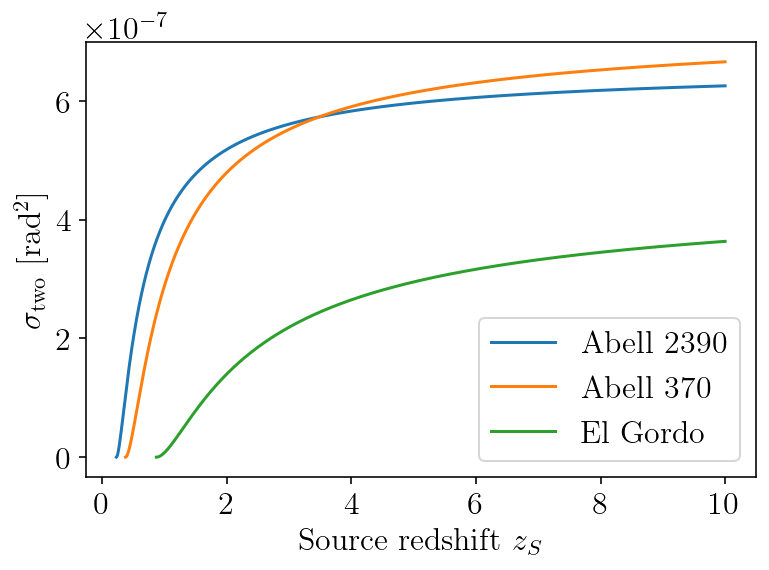

In [10]:
zmax = 10.
zs_Abell2390 = np.linspace(z_Abell2390,zmax,1000)
zs_Abell370 = np.linspace(z_Abell370,zmax,1000)
zs_ElGordo = np.linspace(z_ElGordo,zmax,1000)

plt.plot(zs_Abell2390,sistau.sigma_two_velocity(sigma_Abell2390,z_Abell2390,zs_Abell2390),label='Abell 2390')
plt.plot(zs_Abell370,sistau.sigma_two_velocity(sigma_Abell370,z_Abell370,zs_Abell370),label='Abell 370')
plt.plot(zs_ElGordo,sistau.sigma_two_velocity(sigma_ElGordo,z_ElGordo,zs_ElGordo),label='El Gordo')
plt.xlabel(r'Source redshift $z_S$')
plt.ylabel(r'$\sigma_{\rm two}$ [rad$^2$]')
plt.legend()
plt.show()

## Optical depth for strong lensing

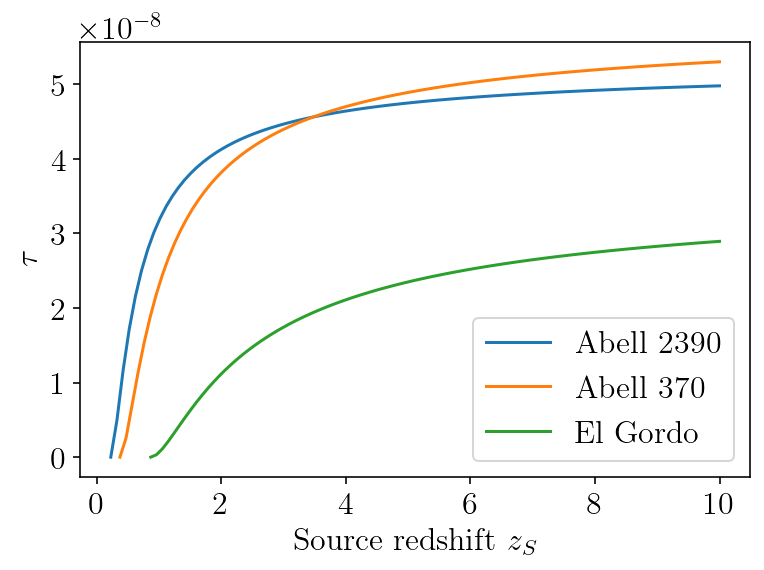

In [11]:
n_z = 100

zs_Abell2390 = np.linspace(z_Abell2390,zmax,n_z)
zs_Abell370 = np.linspace(z_Abell370,zmax,n_z)
zs_ElGordo = np.linspace(z_ElGordo,zmax,n_z)

plt.plot(zs_Abell2390,sistau.tau_singlelens(zs_Abell2390,sigma_Abell2390,z_Abell2390),label='Abell 2390')
plt.plot(zs_Abell370,sistau.tau_singlelens(zs_Abell370,sigma_Abell370,z_Abell370),label='Abell 370')
plt.plot(zs_ElGordo,sistau.tau_singlelens(zs_ElGordo,sigma_ElGordo,z_ElGordo),label='El Gordo')
plt.xlabel(r'Source redshift $z_S$')
plt.ylabel(r'$\tau$')
plt.legend()
plt.show()

## BBH merger rate behind a cluster

In [12]:
zmax = 10.
n_z = 100

Nbbh_Abell2390 = gwrates.Ncbc_behindlens(pz_fid,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,sigma_Abell2390,z_Abell2390,zmax,n_z)
print('BBHs per year behind Abell 2390: ',Nbbh_Abell2390)

Nbbh_Abell370 = gwrates.Ncbc_behindlens(pz_fid,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,sigma_Abell370,z_Abell370,zmax,n_z)
print('BBHs per year behind Abell 370: ',Nbbh_Abell370)

Nbbh_ElGordo = gwrates.Ncbc_behindlens(pz_fid,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,sigma_ElGordo,z_ElGordo,zmax,n_z)
print('BBHs per year behind El Gordo: ',Nbbh_ElGordo)

BBHs per year behind Abell 2390:  0.004855404499274237
BBHs per year behind Abell 370:  0.004535276047529212
BBHs per year behind El Gordo:  0.0015408597610357699


Redshift distribution of BBH mergers behind a cluster

In [16]:
dNbbh_Abell2390_dz = gwrates.dNcbc_behindlens_dz(zs_Abell2390,pz_fid,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,sigma_Abell2390,z_Abell2390)
dNbbh_Abell370_dz = gwrates.dNcbc_behindlens_dz(zs_Abell370,pz_fid,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,sigma_Abell370,z_Abell370)
dNbbh_ElGordo_dz = gwrates.dNcbc_behindlens_dz(zs_ElGordo,pz_fid,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,sigma_ElGordo,z_ElGordo)

In [17]:
zs = np.linspace(0.1,zmax,1000)
dNbbh_dz = gwrates.dNcbc_dz(zs,pz_fid,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs)

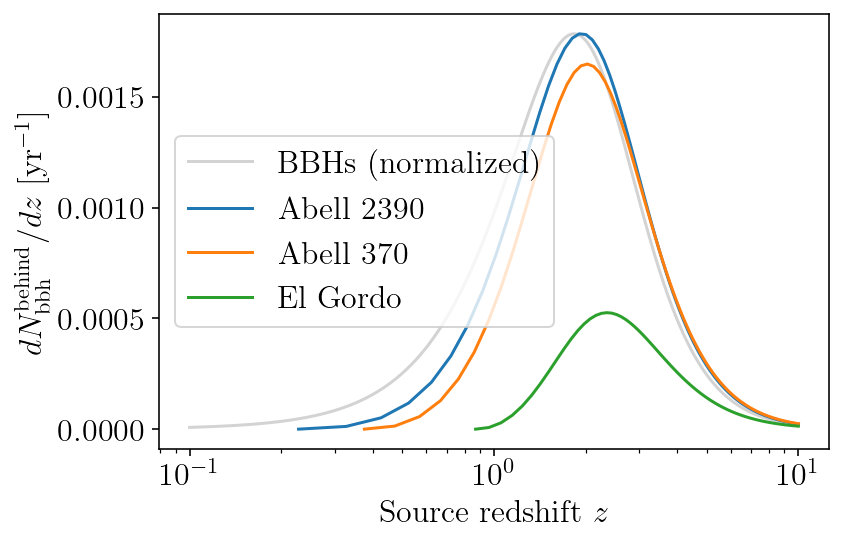

In [18]:
plt.plot(zs,dNbbh_dz*np.max(dNbbh_Abell2390_dz)/np.max(dNbbh_dz),color='lightgray',label='BBHs (normalized)')
plt.plot(zs_Abell2390,dNbbh_Abell2390_dz,label='Abell 2390')
plt.plot(zs_Abell370,dNbbh_Abell370_dz,label='Abell 370')
plt.plot(zs_ElGordo,dNbbh_ElGordo_dz,label='El Gordo')
#plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Source redshift $z$')
plt.ylabel(r'$dN_{\rm bbh}^{\rm behind}/dz$ [yr$^{-1}$]')
plt.legend()
plt.show()

## Detectable BBH mergers behind a cluster

Including the effect of strong lensing!

We compute the number of detectable lensed events. For this we use the magnification distribution of the brightest image

In [19]:
zmin = 0.01
zmax = 10.

n_m1 = 50 #number of mass bins
n_m2 = 10 #number of mass bins
n_z = 50 #number of redshift bins
nys = 10

Nbbh_lens_mup_O4_Abell2390 = sisrates.Ndet_behindlens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,sigma_Abell2390,z_Abell2390,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmax,n_z)
print('Detected lensed primary image of BBHs per year (O4) behind Abell 2390: ',Nbbh_lens_mup_O4_Abell2390)

Nbbh_lens_mup_O4_Abell370 = sisrates.Ndet_behindlens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,sigma_Abell370,z_Abell370,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmax,n_z)
print('Detected lensed primary image of BBHs per year (O4) behind Abell 370: ',Nbbh_lens_mup_O4_Abell370)

Nbbh_lens_mup_O4_ElGordo = sisrates.Ndet_behindlens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,sigma_ElGordo,z_ElGordo,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmax,n_z)
print('Detected lensed primary image of BBHs per year (O4) behind El Gordo: ',Nbbh_lens_mup_O4_ElGordo)

Detected lensed primary image of BBHs per year (O4) behind Abell 2390:  0.0002924872312317616
Detected lensed primary image of BBHs per year (O4) behind Abell 370:  0.0002646082749541826
Detected lensed primary image of BBHs per year (O4) behind El Gordo:  8.437046932063652e-05


Redshift distribution of detectable BBH mergers behind a cluster

In [20]:
zmax = 10.
n_z = 30
nys = 10

zs_Abell2390 = np.linspace(z_Abell2390,zmax,n_z)
zs_Abell370 = np.linspace(z_Abell370,zmax,n_z)
zs_ElGordo = np.linspace(z_ElGordo,zmax,n_z)
    
dNbbh_lens_mup_O4_Abell2390_dz = sisrates.vdNdet_behindlens_mu_dz(zs_Abell2390,pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,sigma_Abell2390,z_Abell2390,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2)
dNbbh_lens_mup_O4_Abell370_dz = sisrates.vdNdet_behindlens_mu_dz(zs_Abell370,pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,sigma_Abell370,z_Abell370,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2)
dNbbh_lens_mup_O4_ElGordo_dz = sisrates.vdNdet_behindlens_mu_dz(zs_ElGordo,pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,sigma_ElGordo,z_ElGordo,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2)

In [21]:
zs = np.linspace(0.1,zmax,n_z)
dNbbh_O4_dz = gwrates.vdNdet_dz(zs,pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,mmin_bbh,mmax_bbh,n_m1,n_m2)

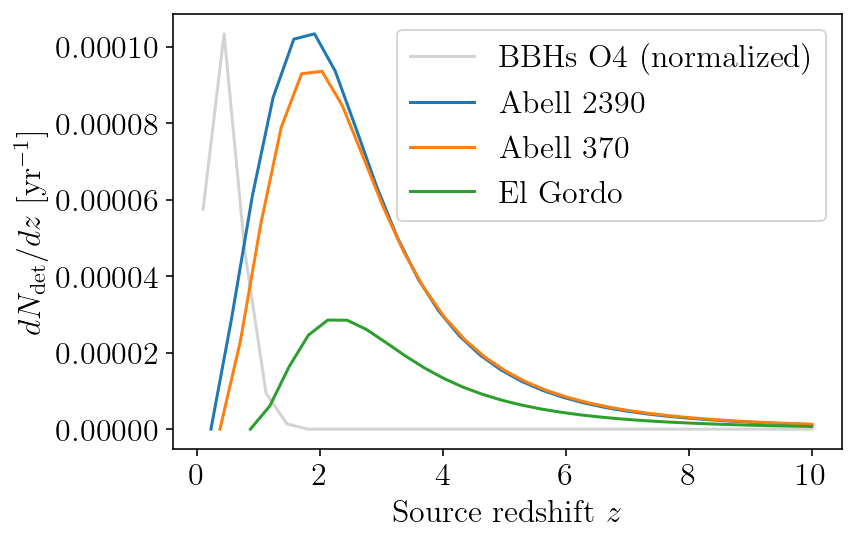

In [22]:
plt.plot(zs,dNbbh_O4_dz*np.max(dNbbh_lens_mup_O4_Abell2390_dz)/np.max(dNbbh_O4_dz),color='lightgray',label='BBHs O4 (normalized)')
plt.plot(zs_Abell2390,dNbbh_lens_mup_O4_Abell2390_dz,label='Abell 2390')
plt.plot(zs_Abell370,dNbbh_lens_mup_O4_Abell370_dz,label='Abell 370')
plt.plot(zs_ElGordo,dNbbh_lens_mup_O4_ElGordo_dz,label='El Gordo')
plt.xlabel(r'Source redshift $z$')
plt.ylabel(r'$dN_{\rm det}/dz$ [yr$^{-1}$]')
plt.legend()
plt.show()

## Monte Carlo integration

We can use Monte Carlo integration to compute the number of detectable BBH mergers behind a cluster. 

\begin{equation}
I = \int f(x)p(x)dx = \frac{1}{N}\sum_{i=1}^N f(x_i)
\end{equation}

where $x_i$ are drawn from the distribution $p(x)$.

We compute the integral in redshift bins and sample from a given source mass distribution and source positions across the cross section

In [15]:
Nmc = 1500

zmax = 10.
n_z = 20
zs_Abell2390 = np.linspace(z_Abell2390,zmax,n_z)
zs_Abell370 = np.linspace(z_Abell370,zmax,n_z)
zs_ElGordo = np.linspace(z_ElGordo,zmax,n_z)

dNbbh_lens_mup_O4_Abell2390_dz_MC, error_dNbbh_lens_mup_O4_Abell2390_dz_MC = sisrates.vdNdet_MC_behindlens_mu_dz(zs_Abell2390,Nmc,pz_fid,pm1_bbh,pq_bbh,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,sigma_Abell2390,z_Abell2390,sis.mu_plus,z_Abell2390,zmax,mmin_bbh,mmax_bbh)
dNbbh_lens_mup_O4_Abell370_dz_MC, error_dNbbh_lens_mup_O4_Abell370_dz_MC = sisrates.vdNdet_MC_behindlens_mu_dz(zs_Abell370,Nmc,pz_fid,pm1_bbh,pq_bbh,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,sigma_Abell370,z_Abell370,sis.mu_plus,z_Abell370,zmax,mmin_bbh,mmax_bbh)
dNbbh_lens_mup_O4_ElGordo_dz_MC, error_dNbbh_lens_mup_O4_ElGordo_dz_MC = sisrates.vdNdet_MC_behindlens_mu_dz(zs_ElGordo,Nmc,pz_fid,pm1_bbh,pq_bbh,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,sigma_ElGordo,z_ElGordo,sis.mu_plus,z_ElGordo,zmax,mmin_bbh,mmax_bbh)

In [16]:
Nbbh_lens_mup_O4_Abell2390_MC, error_Nbbh_lens_mup_O4_Abell2390_MC = trapz(dNbbh_lens_mup_O4_Abell2390_dz_MC,zs_Abell2390), trapz(error_dNbbh_lens_mup_O4_Abell2390_dz_MC,zs_Abell2390)
print('Detected lensed primary image of BBHs per year (O4) behind Abell 2390 (MC): ',f'{Nbbh_lens_mup_O4_Abell2390_MC:.2e}','+/-',f'{error_Nbbh_lens_mup_O4_Abell2390_MC:.2e}')

Nbbh_lens_mup_O4_Abell370_MC, error_Nbbh_lens_mup_O4_Abell370_MC = trapz(dNbbh_lens_mup_O4_Abell370_dz_MC,zs_Abell370), trapz(error_dNbbh_lens_mup_O4_Abell370_dz_MC,zs_Abell370)
print('Detected lensed primary image of BBHs per year (O4) behind Abell 370 (MC): ',f'{Nbbh_lens_mup_O4_Abell370_MC:.2e}','+/-',f'{error_Nbbh_lens_mup_O4_Abell370_MC:.2e}')

Nbbh_lens_mup_O4_ElGordo_MC, error_Nbbh_lens_mup_O4_ElGordo_MC = trapz(dNbbh_lens_mup_O4_ElGordo_dz_MC,zs_ElGordo), trapz(error_dNbbh_lens_mup_O4_ElGordo_dz_MC,zs_ElGordo)
print('Detected lensed primary image of BBHs per year (O4) behind El Gordo (MC): ',f'{Nbbh_lens_mup_O4_ElGordo_MC:.2e}','+/-',f'{error_Nbbh_lens_mup_O4_ElGordo_MC:.2e}')


Detected lensed primary image of BBHs per year (O4) behind Abell 2390 (MC):  1.05e-04 +/- 1.13e-05
Detected lensed primary image of BBHs per year (O4) behind Abell 370 (MC):  8.54e-05 +/- 1.02e-05
Detected lensed primary image of BBHs per year (O4) behind El Gordo (MC):  1.83e-05 +/- 2.76e-06


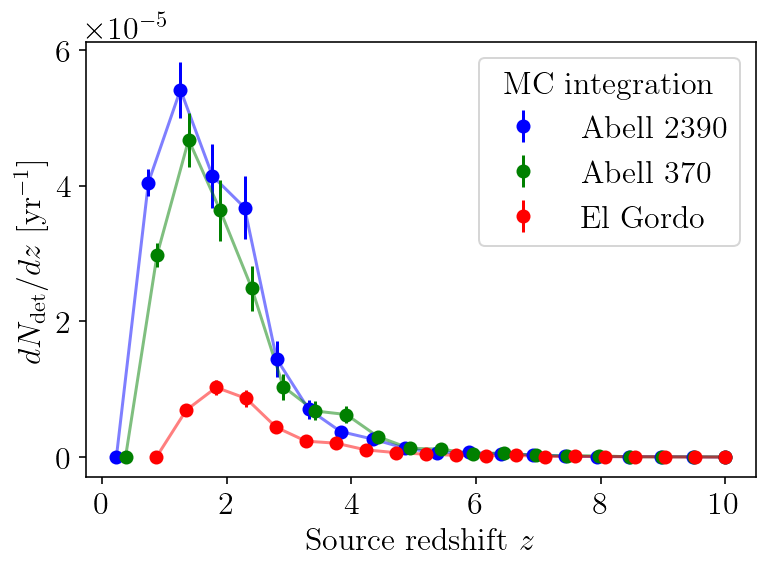

In [17]:
#plt.plot(zs,dNbbh_O4_dz*np.max(dNbbh_lens_mup_O4_Abell2390_dz)/np.max(dNbbh_O4_dz),color='lightgray',label='BBHs O4 (normalized)')

plt.plot(zs_Abell2390,dNbbh_lens_mup_O4_Abell2390_dz_MC,color=color_Abell2390,alpha=0.5)
plt.errorbar(zs_Abell2390,dNbbh_lens_mup_O4_Abell2390_dz_MC,yerr=error_dNbbh_lens_mup_O4_Abell2390_dz_MC,fmt='o',color=color_Abell2390,label='Abell 2390')

plt.plot(zs_Abell370,dNbbh_lens_mup_O4_Abell370_dz_MC,color=color_Abell370,alpha=0.5)
plt.errorbar(zs_Abell370,dNbbh_lens_mup_O4_Abell370_dz_MC,yerr=error_dNbbh_lens_mup_O4_Abell370_dz_MC,fmt='o',color=color_Abell370,label='Abell 370')

plt.plot(zs_ElGordo,dNbbh_lens_mup_O4_ElGordo_dz_MC,color=color_ElGordo,alpha=0.5)
plt.errorbar(zs_ElGordo,dNbbh_lens_mup_O4_ElGordo_dz_MC,yerr=error_dNbbh_lens_mup_O4_ElGordo_dz_MC,fmt='o',color=color_ElGordo,label='El Gordo')

plt.xlabel(r'Source redshift $z$')
plt.ylabel(r'$dN_{\rm det}/dz$ [yr$^{-1}$]')
plt.legend(title='MC integration')
plt.show()